In [1]:
#!pip install lmfit
#!pip install requests
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

In [21]:
r = requests.get('https://api.covid19api.com/dayone/country/morocco')
res=r.json()
df=pd.DataFrame(res)
df.to_csv('ma.csv',index=False)
c=np.array(df['Confirmed'])
a=np.array(df['Active'])
r=np.array(df['Recovered'])
d=np.array(df['Deaths'])
#N=np.max(c)
N=4e7

s=N-a-r-d
p=1
print(np.max(s))
print(N,a.shape[0])

39999999.0
40000000.0 97


In [22]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma):
    S, I, R , D = y
    dSdt = -beta * I *(S/ N)**p
    dIdt = beta * I * (S/ N)**p - (gamma +sigma) * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt


#Test de la fonction deriv
deriv([10, 1, 0, 0],1,N, 1, 0.2, 0.1)



(-2.5e-07, -0.29999975000000006, 0.2, 0.1)

In [23]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma)).T

In [24]:
#Algorithm de l'article de Mr Karami
def fahd(params,x,y0):
    n=x.size
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    
    for k in range(n):
        root=np.sqrt((tau*(gamma+sigma)+1-tau*(beta/N)*(S[k]+I[k]))**2+4.*tau*(beta/N)*(tau*(gamma+sigma)+1.)*I[k])
        rest=(tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k]))
        den=(2.*tau*(beta/N)*(1.+tau*(gamma+sigma)))
        I[k+1]=(root -rest)/den
        S[k+1]=S[k]/(1+tau*(beta/N)*I[k+1])
        R[k+1]=R[k]+tau*gamma*I[k+1]
        D[k+1]=D[k]+tau*sigma*I[k+1]
    S=S[0:-1].tolist()
    I=I[0:-1].tolist()
    R=R[0:-1].tolist()
    D=D[0:-1].tolist()
    return np.array([S,I,R,D])

  

In [25]:
fit_params = Parameters()
fit_params.add('N', value=N,vary=False)
fit_params.add('p', value=1, vary=True,min=1, max=40)
fit_params.add('beta', value=0.2, min=0, max=4.0)
fit_params.add('gamma', value=0.02, min=0, max=1.0)
fit_params.add('sigma', value=0.01, min=0, max=1.0)
N=fit_params['N'].value
print('N:',N)
#Test de f
#x=np.linspace(1,2,10)
y0=[N-1,1,0,0]
data=np.array([s[1:],a[1:],r[1:],d[1:]])

N: 40000000.0


CPU times: user 44.5 ms, sys: 0 ns, total: 44.5 ms
Wall time: 42.9 ms


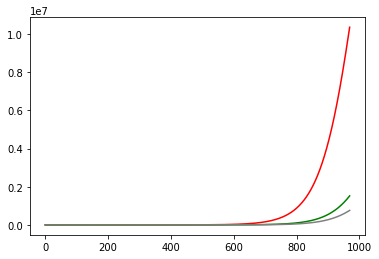

In [26]:
%%time
#Resolution using Fahd
tau = .1
x=np.linspace(tau,a.shape[0],int((a.shape[0])/tau))
y=fahd(fit_params,x,y0)

#Plot estimated data using odint
#plt.plot(y[0], label="Sr",color='blue')
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

CPU times: user 38.3 ms, sys: 21 µs, total: 38.4 ms
Wall time: 37.5 ms


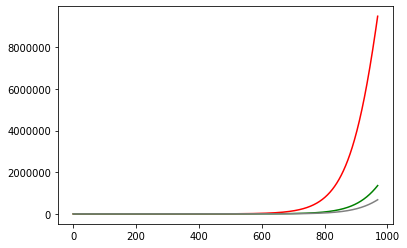

In [27]:
%%time
#Resolution using odint
p=1
y=f(fit_params,x,y0)

#Plot estimated data using odint
#plt.plot(y[0], label="Sr",color='blue')
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

In [28]:
#Algorithm de l'article de Mr Karami
def fahdFix(params,x,y0):
    n=x.size
    N= params["N"]
    pp= params["p"].value
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    P=np.ones(n+1)
    for i in range(tc,tc+eps+1):
      P[i]=1+(pp-1)*(i-tc)/eps 
    for i in range(tc+eps+1,n+1):
      P[i]=pp 
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    theta=(S[0]/N)**(P[0]-1)
    for k in range(n):
        Err=1
        II=I[k]
        theta=(S[k]/N)**(P[k]-1)
        while Err>1e-10:
            root=np.sqrt((tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k])*theta)**2+(4*tau*(beta/N)*(tau*(gamma+sigma)+1)*theta*I[k]))
            rest=(tau*(gamma+sigma)+1)-tau*(beta/N)*(S[k]+I[k])*theta
            den=2*tau*(beta/N)*(1.+tau*(gamma+sigma))*theta
            III=(root-rest)/den
            SS=S[k]/(1.+(tau*(beta/N)*III*theta))
            RR=R[k]+tau*gamma*III
            DD=D[k]+tau*sigma*III
            theta1=(SS/N)**(P[k+1]-1)
            #Err=abs(II-III)
            Err=abs(theta-theta1)
            II=III
            theta=theta1
            #print(Err)
        S[k+1],I[k+1],R[k+1],D[k+1]=SS,II,RR,DD
        #print("===========================================================================")
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

CPU times: user 119 ms, sys: 3.99 ms, total: 123 ms
Wall time: 121 ms


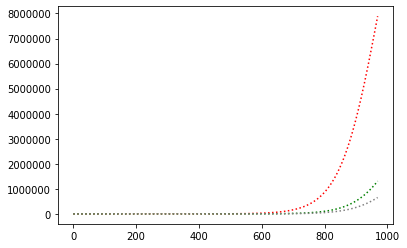

In [29]:
%%time
#Resolution using fahdFix
tau=0.1
tc=int(30/tau)#confinement
eps=10
n=x.size
fit_params["p"].value=2
#print(P)
yf=fahdFix(fit_params,x,y0)
#Plot estimated data using Mr karami's Algorithm
#plt.plot(yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yf[3],linestyle='dotted',label="Ds", color='gray')

#plt.legend()

In [30]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shape
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    
    for i in range(1,ndata):
        resid[i, :] = data[i, :] - ret[i,:]
    #resid=data[0, :] - ret[0,:]
    return resid.flatten()

[[Variables]]
    N:      4e+07 (fixed)
    p:      38.2937631 +/- 260.523304 (680.33%) (init = 1)
    beta:   0.30803522 +/- 0.03543850 (11.50%) (init = 0.2)
    gamma:  0.22098157 +/- 0.03367522 (15.24%) (init = 0.02)
    sigma:  0.00510485 +/- 0.00927869 (181.76%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.951
    C(p, gamma)    = -0.574
    C(p, beta)     = -0.466
    C(beta, sigma) =  0.374
    C(p, sigma)    =  0.127
(4, 96) (4, 96) (4, 96)


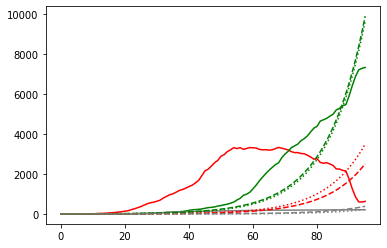

In [34]:
y0=[N-1,1,0,0]
tau = .01
tc=0 #confinement
eps=1
X=np.linspace(tau,a.shape[0],int((a.shape[0])/tau))
npArray = np.arange(0,int((a.shape[0]-1)/tau) , int(1/tau))
yyy=X[npArray]

outf = minimize(objective, fit_params,  args=(fahdFix,yyy,data,y0))
fit_params["p"].value=1
out = minimize(objective, fit_params,  args=(f,yyy,data,y0))

#report_fit(out.params)
report_fit(outf.params)
y=f(out.params,yyy,[N-1,1,0,0])
yf=fahdFix(outf.params,yyy,[N-1,1,0,0])

## Plot real data
#plt.plot(data[0],label="Sr", color='blue')
plt.plot(data[1],label="Ir", color='red')
plt.plot(data[2],label="Rr", color='green')
plt.plot(data[3],label="Dr", color='gray')

#Plot estimated data using odint
#plt.plot(yyy,y[0], label="Sr",linestyle='dashed',color='blue')
plt.plot(yyy,y[1], label="Is",linestyle='dashed',color='red')
plt.plot(yyy,y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(yyy,y[3],label="Ds",linestyle='dashed', color='gray')

#Plot estimated data using Mr karami's Algorithm
#plt.plot(yyy,yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yyy,yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yyy,yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yyy,yf[3],linestyle='dotted',label="Ds", color='gray')

print(y.shape,yf.shape,data.shape)
#plt.legend()


In [32]:

#hadi ca pourra t aider elle prend que les element qui nous interesse 
npArray = np.arange(1,int((a.shape[0]-1)/tau) , int(1/tau))
yyy=X[npArray]